In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")
import logging

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [160]:
# Custom rc definitions
rc = {
        'axes.spines.right': True,
        'axes.spines.top': True,
        'font.family': ['sans-serif'],
        'font.sans-serif':
        # 'Arial',
        'DejaVu Sans',
        # 'Liberation Sans',
        # 'Bitstream Vera Sans',
        # 'sans-serif',
        "xtick.bottom":True,
        'axes.edgecolor': 'indigo',
        'xtick.color': 'black',
        'figure.facecolor': "snow",
        'grid.color': 'grey',
        
}


# font definitions
font_label = {'family': 'serif',
        'color':  'darkred',
        'weight': 'semibold',
        'size': 16,
        }

font_title = {'family': 'serif',
        'color':  'black',
        'weight': 'semibold',
        'size': 16,
        }

font_fig = {'family': 'sans',
        'color':  'chocolate',
        # 'weight': 'bold', # doesn't apply to it. Must be specified independently
        # 'fontsize': 30, # doesn't apply to it. Must be specified independently
        }

In [4]:
data = pd.read_csv('../../data/topic_data.csv')

In [5]:
data.sample(2,random_state=42)

review_title  review_title_length  \
828                          Great mouse for the price.                    5   
1097  Poor Construction and recharge is by a cord - ...                   11   

                                             the_review  the_review_length  \
828       It turns on but the left button does not work                 10   
1097  We bought this for my son to use and it lasted...                 18   

      review_score  year  month month_name  day  
828            4.0  2022      6       June   16  
1097           1.0  2022      5        May    9

In [6]:
data_copy = data.copy()

In [7]:
data_copy.describe()

review_title_length  the_review_length  review_score          year  \
count         17640.000000       17640.000000  17640.000000  17640.000000   
mean              3.933107          32.164909      3.627551   2021.114172   
std               2.755171          38.073438      1.686209      0.814506   
min               1.000000           1.000000      1.000000   2018.000000   
25%               2.000000           9.000000      2.000000   2021.000000   
50%               3.000000          21.000000      5.000000   2021.000000   
75%               5.000000          41.000000      5.000000   2022.000000   
max              23.000000         600.000000      5.000000   2022.000000   

              month           day  
count  17640.000000  17640.000000  
mean       6.060488     15.764966  
std        3.196340      8.750064  
min        1.000000      1.000000  
25%        3.000000      8.000000  
50%        6.000000     16.000000  
75%        9.000000     23.000000  
max       12.000000     31.000000

### **Memory management**

In [8]:
data_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   review_title         17640 non-null  object 
 1   review_title_length  17640 non-null  int64  
 2   the_review           17640 non-null  object 
 3   the_review_length    17640 non-null  int64  
 4   review_score         17640 non-null  float64
 5   year                 17640 non-null  int64  
 6   month                17640 non-null  int64  
 7   month_name           17640 non-null  object 
 8   day                  17640 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 7.8 MB


In [9]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        cond1 = (col_type == np.object ) or (col_type == pd.CategoricalDtype)
        if cond1:
            df[col] = df[col].astype('category')  
        else:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].round(3)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].round(3)
                else:
                    df[col] = df[col].round(3) # float64

    return df

data_memory = data_copy.copy()
data_memory = memory_magment(data_memory)

In [10]:
data_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   review_title         17640 non-null  category
 1   review_title_length  17640 non-null  int8    
 2   the_review           17640 non-null  category
 3   the_review_length    17640 non-null  int16   
 4   review_score         17640 non-null  float64 
 5   year                 17640 non-null  int16   
 6   month                17640 non-null  int8    
 7   month_name           17640 non-null  category
 8   day                  17640 non-null  int8    
dtypes: category(3), float64(1), int16(2), int8(3)
memory usage: 5.9 MB


In [11]:
data_memory.sample(n=2,random_state=42)

review_title  review_title_length  \
828                          Great mouse for the price.                    5   
1097  Poor Construction and recharge is by a cord - ...                   11   

                                             the_review  the_review_length  \
828       It turns on but the left button does not work                 10   
1097  We bought this for my son to use and it lasted...                 18   

      review_score  year  month month_name  day  
828            4.0  2022      6       June   16  
1097           1.0  2022      5        May    9

### **Text Analytics**

In [12]:
text_eda = data_memory.copy()

In [13]:
(
    text_eda.year.value_counts().to_frame().
    reset_index().
    rename(columns={"index":"year", "year":"total_count"}).
    sort_values('total_count')
 )

year  total_count
4  2018           22
3  2019          967
2  2020         1926
1  2022         5940
0  2021         8785

In [14]:
(
    text_eda.month_name.value_counts().to_frame().
    reset_index().
    rename(columns={"index":"month_name", "month_name":"total_count"}).
    sort_values('total_count')
 )

month_name  total_count
11   November          838
10   December          995
9    February         1126
8   September         1308
7     January         1309
6     October         1351
5        June         1376
4         May         1677
3      August         1696
2       April         1717
1        July         1772
0       March         2475

In [15]:
(
    text_eda.day.value_counts().to_frame().
    reset_index().
    rename(columns={"index":"day", "day":"total_count"}).
    sort_values('total_count').head()
 ) # top 5 days

day  total_count
30   31          311
29   30          454
28   11          504
27   24          522
26    1          527

### **Text Preprocessing**

In [16]:
text_cleaning = text_eda.copy()

In [ ]:
def preprocess(sent):
    '''Cleans text data up, leaving only 2 or
        more char long non-stopwords composed of A-Z & a-z only
        in lowercase'''
    # lowercase
    sentence = sent.lower()

    # Remove RT
    sentence = re.sub('RT @\w+: '," ",sentence)

    # Remove special characters
    sentence = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence)

    # Removing digits
    sentence = sentence.translate(str.maketrans('', '', string.digits))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 
    # When we remove apostrophe from the word "Mark's", 
    # the apostrophe is replaced by an empty space. 
    # Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Next, we remove all the single characters and replace it by a space 
    # which creates multiple spaces in our text. 
    # Finally, we remove the multiple spaces from our text as well.

    return sentence


In [18]:
text_cleaning['cleaned_review'] = text_cleaning.the_review.apply(preprocess)
text_cleaning['cleaned_review_title'] = text_cleaning.review_title.apply(preprocess)

In [19]:
text_cleaning.sample(2,random_state=42)

review_title  review_title_length  \
828                          Great mouse for the price.                    5   
1097  Poor Construction and recharge is by a cord - ...                   11   

                                             the_review  the_review_length  \
828       It turns on but the left button does not work                 10   
1097  We bought this for my son to use and it lasted...                 18   

      review_score  year  month month_name  day  \
828            4.0  2022      6       June   16   
1097           1.0  2022      5        May    9   

                                         cleaned_review  \
828       it turns on but the left button does not work   
1097  we bought this for my son to use and it lasted...   

                                   cleaned_review_title  
828                          great mouse for the price   
1097  poor construction and recharge is by cord no b...

In [20]:
reorder = [
'review_title',
'review_title_length',
'cleaned_review_title',
'the_review',
'the_review_length',
'cleaned_review',
'review_score',
'year',
'month',
'month_name',
'day',
]
text_cleaning = text_cleaning[reorder]

In [21]:
text_cleaning.sample(2,random_state=42)

review_title  review_title_length  \
828                          Great mouse for the price.                    5   
1097  Poor Construction and recharge is by a cord - ...                   11   

                                   cleaned_review_title  \
828                          great mouse for the price    
1097  poor construction and recharge is by cord no b...   

                                             the_review  the_review_length  \
828       It turns on but the left button does not work                 10   
1097  We bought this for my son to use and it lasted...                 18   

                                         cleaned_review  review_score  year  \
828       it turns on but the left button does not work           4.0  2022   
1097  we bought this for my son to use and it lasted...           1.0  2022   

      month month_name  day  
828       6       June   16  
1097      5        May    9

In [22]:
selected_features = ['cleaned_review_title',
                     'cleaned_review','year',
                     'month_name','day']
feature_data = (text_cleaning[selected_features].
                rename(columns={'month_name':"month"}))
feature_data.columns.to_list()

['cleaned_review_title', 'cleaned_review', 'year', 'month', 'day']

In [23]:
feature_data.sample(2,random_state=42)

cleaned_review_title  \
828                          great mouse for the price    
1097  poor construction and recharge is by cord no b...   

                                         cleaned_review  year month  day  
828       it turns on but the left button does not work  2022  June   16  
1097  we bought this for my son to use and it lasted...  2022   May    9

In [24]:
from spacy.lang.en.stop_words import STOP_WORDS

all_stopwords = {"'d","'ll","'m","'re","'s","'ve",'a','about',
'above','across','after','afterwards','again','all','almost','alone','along',
'already','also','although','always','am','among','amongst','amount','an','and',
'another','any','anyhow','anyone','anything','anyway','anywhere','are','around',
'as','at','back','be','became','because','become','becomes','becoming','been','before',
'beforehand','behind','being','below','beside','besides','between','both','bottom',
'but','by','ca','call','can','could','did','do','does','doing','done','down','due','during','each',
'eight','either','eleven','else','elsewhere','empty','even','everyone','everything',
'everywhere','except','few','fifteen','fifty','first','five','for','former','formerly','forty','four','from','front',
'full','further','go','had','has','have','he','hence','her','here','hereafter','hereby','herein','hereupon','hers',
'herself','him','himself','his','how','however','hundred','i','if','in','indeed','into','is','it','its','itself','just','keep','last',
'latter','latterly','made','make','many','may','me','meanwhile','might','mine','more','moreover','move','much',
'must','my','myself','name','namely','neither','nevertheless','next','nine','nobody','noone','nothing','now','nowhere','of','often',
'on','once','one','only','onto','or','other','others','otherwise','our','ours','ourselves','out','own','part','per','perhaps','please','put',
'rather','re','regarding','same','say','see','several','she','should','show','side',
'since','six','sixty','so','some','somehow','someone','something','sometime','sometimes','somewhere','still','such','take','ten','than','that','the','their',
'them','themselves','then','thence','there','thereafter','thereby','therefore','therein','thereupon','these','they','third','this','those','though','three',
'through','throughout','thru','thus','to','together','top','toward','towards','twelve','twenty','two','under','unless','until','up','upon','us','used','using',
'various','via','was','we','well','were','what','whatever','when','whence','whenever','where','whereafter','whereas','whereby','wherein','whereupon',
'wherever','whether','which','while','whither','who','whoever','whole','whom','whose','why','will','with','within','would','yet','you','your','yours','yourself',
'yourselves','‘d','‘ll','‘m','‘re','‘s','‘ve','’d','’ll','’m','’re','’s','’ve'}

my_stop_words = set(all_stopwords) # My own stop words

# https://spacy.io/usage/processing-pipelines#disabling
# Load the pipeline without the entity recognizer
nlp = spacy.load("en_core_web_sm", exclude=["tagger", "ner",'attribute_ruler'])

# Load the tagger and parser but don't enable them
# nlp = spacy.load("en_core_web_sm", disable=["tagger", "ner",'attribute_ruler'])
# # Explicitly enable the tagger later on
# nlp.enable_pipe("tagger")
nlp.pipe_names

['tok2vec', 'parser', 'lemmatizer']

In [25]:
# text = ["I really love dogs like           that   "]
# print(text[0].strip())
# text_c = preprocess(text[0]) # This is why preprocess function is needed
# print(text_c)

In [26]:
# text_ = nlp(text[0].lower())
# for word in text_:
#     # print(word.text.lower())
#     if word.text not in my_stop_words:
#         print(word.lemma_)

# # # really
# # # love
# # # dog
# # # like

In [27]:
def spacy_tokeniser(sentence):
    sentence  = sentence.strip().lower()
    doc = nlp(sentence)
    my_tokens = [word.lemma_ for word in doc if word.text not in my_stop_words]
    return my_tokens

feature_data['tokens'] = feature_data['cleaned_review'].apply(spacy_tokeniser)

In [28]:
text_cleaning.the_review[0]

'I wish I would have gotten one earlier. I love it and it makes working in my laptop so much easier'

In [29]:
feature_data.cleaned_review[0]

'i wish would have gotten one earlier love it and it makes working in my laptop so much easier'

In [30]:
feature_data.tokens[0]

['wish', 'gotten', 'earlier', 'love', 'makes', 'working', 'laptop', 'easier']

In [31]:
reorder = ['cleaned_review_title', 'cleaned_review','tokens' ,'year', 'month', 'day']
feature_data = feature_data[reorder]

### **Topic Modelling Preprocessing**

In [32]:
# Compute bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser,ENGLISH_CONNECTOR_WORDS

In [33]:
docs = feature_data.tokens.tolist()
print(docs[0]) # from document 1
print(len(docs[0])) # Length of the document
print(docs[0][:4]) # slicing the document

['wish', 'gotten', 'earlier', 'love', 'makes', 'working', 'laptop', 'easier']
8
['wish', 'gotten', 'earlier', 'love']


In [34]:
# Add bigrams to docs (only ones that appear 20 times or more).
# https://stackoverflow.com/questions/35716121/how-to-extract-phrases-from-corpus-using-gensim
# https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.original_scorer
# This is using the default scorer and not the robust scorer; npmi
bigram_phrases = Phrases(docs,
                         min_count=20,
                         connector_words=ENGLISH_CONNECTOR_WORDS
                        )

2025-10-12 10:20:55,276 : INFO : collecting all words and their counts
2025-10-12 10:20:55,276 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2025-10-12 10:20:55,463 : INFO : PROGRESS: at sentence #10000, processed 163682 words and 61924 word types
2025-10-12 10:20:55,591 : INFO : collected 113617 token types (unigram + bigrams) from a corpus of 266254 words and 17640 sentences
2025-10-12 10:20:55,591 : INFO : merged Phrases<113617 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2025-10-12 10:20:55,591 : INFO : Phrases lifecycle event {'msg': 'built Phrases<113617 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.31s', 'datetime': '2025-10-12T10:20:55.591518', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}


In [35]:
bigram = Phraser(bigram_phrases)

2025-10-12 10:20:55,623 : INFO : exporting phrases from Phrases<113617 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2025-10-12 10:20:55,862 : INFO : FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<178 phrases, min_count=20, threshold=10.0> from Phrases<113617 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 0.24s', 'datetime': '2025-10-12T10:20:55.862495', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}


In [36]:
def make_bigram(texts):
    return ([bigram[doc] for doc in texts])

In [37]:
bigram_docs = make_bigram(docs)

In [38]:
print(bigram_docs[200][:])

['got', 'mouse', 'charged', 'like', 'said', 'went', 'use', 'doesn_work', 'not', 'recomend', 'get', 'mouse']


In [39]:
# Remove rare and common tokens 
from gensim.corpora import Dictionary
id2word = Dictionary(bigram_docs)
# or 
# dictionary = Dictionary(docs)

2025-10-12 10:20:56,494 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2025-10-12 10:20:56,695 : INFO : adding document #10000 to Dictionary<6169 unique tokens: ['earlier', 'easier', 'gotten', 'laptop', 'love']...>
2025-10-12 10:20:56,838 : INFO : built Dictionary<9390 unique tokens: ['earlier', 'easier', 'gotten', 'laptop', 'love']...> from 17640 documents (total 252044 corpus positions)
2025-10-12 10:20:56,838 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<9390 unique tokens: ['earlier', 'easier', 'gotten', 'laptop', 'love']...> from 17640 documents (total 252044 corpus positions)", 'datetime': '2025-10-12T10:20:56.838613', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}


In [40]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
# https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
id2word.filter_extremes(no_below=20,no_above=0.5)

2025-10-12 10:20:56,870 : INFO : discarding 7870 tokens: [('earlier', 7), ('ceased', 4), ('learned', 12), ('lesson', 6), ('optical', 14), ('packed', 4), ('pnw', 2), ('visiting', 2), ('fabulous', 11), ('fallen', 12)]...
2025-10-12 10:20:56,870 : INFO : keeping 1520 tokens which were in no less than 20 and no more than 8820 (=50.0%) documents


2025-10-12 10:20:56,885 : INFO : resulting dictionary: Dictionary<1520 unique tokens: ['easier', 'gotten', 'laptop', 'love', 'makes']...>


In [41]:
id2word.most_common(10) # most common words
# # [('mouse', 6942),
# # ('not', 5480),
# # ('great', 4642),
# # ('use', 3511),
# # ('very', 3071),
# # ('good', 2981),
# # ('like', 2457),
# # ('work', 2419),
# # ('love', 2337),
# # ('charge', 2190)]

[('mouse', 6942),
 ('not', 5480),
 ('great', 4642),
 ('use', 3511),
 ('very', 3071),
 ('good', 2981),
 ('like', 2457),
 ('work', 2419),
 ('love', 2337),
 ('charge', 2190)]

In [42]:
# Bag-of-words representation of the documents.
# Term document frequency 
bow_corpus = [id2word.doc2bow(doc) for doc in bigram_docs]

In [43]:
# Create texts for umass-coherence-metric
texts = bigram_docs

In [44]:
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(bow_corpus)}')

Number of unique tokens: 1520
Number of documents: 17640


In [45]:
feature_data.columns

Index(['cleaned_review_title', 'cleaned_review', 'tokens', 'year', 'month',
       'day'],
      dtype='object')

In [46]:
len(text_cleaning)

17640

In [47]:
print("Original review:")
print(f"{text_cleaning.loc[200,'the_review']}\n")
print("Cleaned review:")
print(f"{feature_data.loc[200,'cleaned_review']}\n")
print("Review tokens:")
print(f"{feature_data.loc[200,'tokens']}\n")
print("Review tokens bigrams:")
print(bigram_docs[200][:])

Original review:
I got this mouse and i charged it like it said to but when i went to use it it doesn't even work. I would not recomend anyone to get this mouse.

Cleaned review:
i got this mouse and charged it like it said to but when went to use it it doesn even work would not recomend anyone to get this mouse 

Review tokens:
['got', 'mouse', 'charged', 'like', 'said', 'went', 'use', 'doesn', 'work', 'not', 'recomend', 'get', 'mouse']

Review tokens bigrams:
['got', 'mouse', 'charged', 'like', 'said', 'went', 'use', 'doesn_work', 'not', 'recomend', 'get', 'mouse']


In [48]:
# Verifying BOW is set up correctly
def text_checking(original_dataframe,
                  cleaned_data_frame,
                  bow_corpus,
                  id2word,
                  index_number:int=200):
    try:
        print(f"Original review:\n{original_dataframe.loc[index_number,'the_review']}\n")
        print(f"Cleaned review:\n{cleaned_data_frame.loc[index_number,'cleaned_review']}\n")
        print(f"Review tokens:{cleaned_data_frame.loc[index_number,'tokens']}\n")
        print(f"Review tokens bigrams:\n {bigram_docs[index_number][:]}\n")
        print(f"Bow of representation: \n{bow_corpus[index_number]}\n")
        document = bow_corpus[index_number]
        for i in range(len(document)):
            print(f"Word {document[i][0]}, {id2word[document[i][0]]} appears {document[i][1]}")
    except ValueError:
        print(f"The range of the data is {len(cleaned_data_frame)}")
    except KeyError:
        print(f"The range of the data is {len(cleaned_data_frame)}")
text_checking(text_cleaning,feature_data,bow_corpus,id2word,200)

Original review:
I got this mouse and i charged it like it said to but when i went to use it it doesn't even work. I would not recomend anyone to get this mouse.

Cleaned review:
i got this mouse and charged it like it said to but when went to use it it doesn even work would not recomend anyone to get this mouse 

Review tokens:['got', 'mouse', 'charged', 'like', 'said', 'went', 'use', 'doesn', 'work', 'not', 'recomend', 'get', 'mouse']

Review tokens bigrams:
 ['got', 'mouse', 'charged', 'like', 'said', 'went', 'use', 'doesn_work', 'not', 'recomend', 'get', 'mouse']

Bow of representation: 
[(19, 2), (32, 1), (49, 1), (50, 1), (87, 1), (119, 1), (277, 1), (307, 1), (326, 1), (497, 1)]

Word 19, mouse appears 2
Word 32, use appears 1
Word 49, like appears 1
Word 50, not appears 1
Word 87, got appears 1
Word 119, get appears 1
Word 277, said appears 1
Word 307, doesn_work appears 1
Word 326, charged appears 1
Word 497, went appears 1


### **Determining Best Number of Topics**

In [49]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import LdaMulticore,ldamodel
from gensim.models.coherencemodel import CoherenceModel

[Link](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html)

**chunksize** controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.

**passes** controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. 

**iterations** is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough.

one_documnent * passes * iterations = evaluation_gotten

So one corpus(17640) * passes (200) * iterations  (400) = 1.4112e^9

In [50]:
def compute_coherence_score(corpus,dictionary,\
                            texts=None,num_topics=4,\
                            passes=50,iterations=100,
                            chunksize=600,eval_every=None,\
                                coherence_metric="u_mass"):
    '''
    Coherence measure to be used. Fastest method - 
    ‘u_mass’, ‘c_uci’ also known as c_pmi. For ‘u_mass’ corpus should be provided, 
    if texts is provided, it will be converted to corpus using the dictionary. 
    For ‘c_v’, ‘c_uci’ and ‘c_npmi’ texts should be provided (corpus isn’t needed)
    '''
    
    if coherence_metric == "u_mass":
        # LDA Model
        topic_model = LdaMulticore(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            chunksize=chunksize,
            passes=passes,
            iterations=iterations,
            # for reproduction of code
            random_state=100,
            # Setting eval_every=1 makes the model slower due to 
            # evaluating model perplexity, which takes too much time.
            eval_every=eval_every)
        
        # Coherence Score Evluation
        coherence_scoring = CoherenceModel(
            model = topic_model,
            # texts=texts,
            corpus = corpus,
            coherence=coherence_metric,
            processes=-2)
    else:
        print("Texts are requeired for other evaluation metrics other than u_mass")

    return coherence_scoring.get_coherence()

In [51]:
model_results = {
    "topics": [],
    "coherence_score": []
}

start,stop= 2,10

In [52]:
# iterate through the number of topics
for topic in range(start,stop+1):
    print(f"Processing for Topic {topic}\n")
    score = compute_coherence_score(corpus=bow_corpus,
                                    dictionary=id2word,
                                    num_topics=topic)
    model_results['topics'].append(topic)
    model_results['coherence_score'].append(score)

2025-10-12 10:20:59,508 : INFO : using symmetric alpha at 0.5
2025-10-12 10:20:59,508 : INFO : using symmetric eta at 0.5
2025-10-12 10:20:59,508 : INFO : using serial LDA version on this node
2025-10-12 10:20:59,508 : INFO : running online LDA training, 2 topics, 50 passes over the supplied corpus of 17640 documents, updating every 4200 documents, evaluating every ~0 documents, iterating 100x with a convergence threshold of 0.001000
2025-10-12 10:20:59,508 : INFO : training LDA model using 7 processes


Processing for Topic 2



2025-10-12 10:21:08,121 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:21:08,121 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:21:08,121 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:21:08,134 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:21:08,134 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:21:08,143 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:21:08,149 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:21:08,153 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 3



2025-10-12 10:22:55,558 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:22:55,558 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:22:55,558 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:22:55,573 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:22:55,575 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:22:55,579 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:22:55,587 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:22:55,593 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 4



2025-10-12 10:25:04,833 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:25:04,833 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:25:04,833 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:25:04,833 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:25:04,849 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:25:04,856 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:25:04,860 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:25:04,866 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 5



2025-10-12 10:27:19,807 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:27:19,821 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:27:19,826 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:27:19,830 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:27:19,834 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:27:19,839 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:27:19,843 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:27:19,849 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 6



2025-10-12 10:29:30,179 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:29:30,196 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:29:30,196 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:29:30,196 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:29:30,196 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:29:30,215 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:29:30,219 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:29:30,220 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 7



2025-10-12 10:31:38,255 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:31:38,259 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:31:38,259 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:31:38,270 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:31:38,274 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:31:38,279 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:31:38,283 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:31:38,288 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 8



2025-10-12 10:33:50,234 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:33:50,234 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:33:50,244 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:33:50,248 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:33:50,254 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:33:50,258 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:33:50,263 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:33:50,267 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 9



2025-10-12 10:35:55,281 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:35:55,285 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:35:55,288 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:35:55,295 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:35:55,299 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:35:55,301 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:35:55,303 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:35:55,304 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

Processing for Topic 10



2025-10-12 10:37:59,131 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:37:59,146 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:37:59,148 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:37:59,148 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outstanding queue size 4
2025-10-12 10:37:59,148 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #3000/17640, outstanding queue size 5
2025-10-12 10:37:59,164 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #3600/17640, outstanding queue size 6
2025-10-12 10:37:59,168 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #4200/17640, outstanding queue size 7
2025-10-12 10:37:59,172 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #4800/17640, outstandin

In [53]:
model_results

{'topics': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'coherence_score': [-2.415756445376646,
  -2.5080750687365776,
  -2.4304174232974978,
  -2.526835702671044,
  -2.56882314698142,
  -2.844191869196481,
  -2.650314007123983,
  -2.952757159072884,
  -2.857346893272193]}

In [54]:
model_results_frame = pd.DataFrame(model_results)

In [55]:
model_results_frame.sort_values('coherence_score')

topics  coherence_score
7       9        -2.952757
8      10        -2.857347
5       7        -2.844192
6       8        -2.650314
4       6        -2.568823
3       5        -2.526836
1       3        -2.508075
2       4        -2.430417
0       2        -2.415756

- The best topic model for umass bigrams; 2 or  4 topics are good enough
    - 2 topics: -2.430417 coherence score
    - 4 topics: -2.415756
- will perform further investigations

In [57]:
# Exporting the results
model_results_frame.to_csv("results/bigrams/topics_scores/bigrams_results_umass.csv", index=False)

In [58]:
def plotting_lines(data,x:str,y:str):
    try:
        sns.set_theme(style='darkgrid',palette='husl',rc=rc)
        fig,ax = plt.subplots(figsize=(10,5))
        sns.lineplot(data=data,x=x,y=y)
        ax.set_title(f'Line plot of {x} vs {y}',fontdict=font_title)
        ax.set_xlabel(f'{x}',fontdict=font_label)
        ax.set_ylabel(f'{y}',fontdict=font_label)
        plt.savefig("results/bigrams/visuals/topic_coherence_scores.png")
    except ValueError:
        print(f"The wrong Key was passed\nPlease look are the information below\n")
        data.info(memory_usage='deep')

c:\Users\DANNY\Desktop\machtensor\tf\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\DANNY\Desktop\machtensor\tf\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


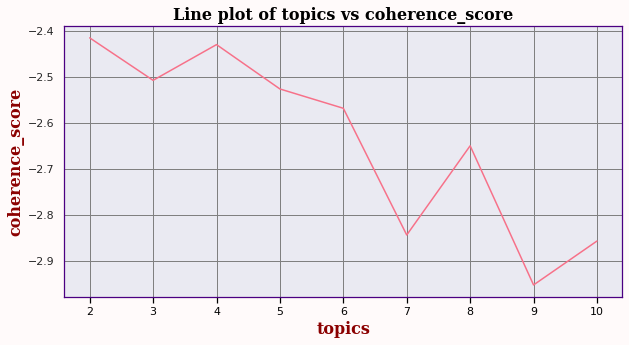

In [61]:
plotting_lines(model_results_frame,"topics","coherence_score")

In [62]:
zipped_values = zip(*model_results.values())
print(list(zipped_values))

[(2, -2.415756445376646), (3, -2.5080750687365776), (4, -2.4304174232974978), (5, -2.526835702671044), (6, -2.56882314698142), (7, -2.844191869196481), (8, -2.650314007123983), (9, -2.952757159072884), (10, -2.857346893272193)]


In [63]:
coherence_scores = []
for topic, coherence_score in zip(*model_results.values()):
    print(f"Topic {topic} has a coherence score of {coherence_score}")
    coherence_scores.append(coherence_score)

Topic 2 has a coherence score of -2.415756445376646
Topic 3 has a coherence score of -2.5080750687365776
Topic 4 has a coherence score of -2.4304174232974978
Topic 5 has a coherence score of -2.526835702671044
Topic 6 has a coherence score of -2.56882314698142
Topic 7 has a coherence score of -2.844191869196481
Topic 8 has a coherence score of -2.650314007123983
Topic 9 has a coherence score of -2.952757159072884
Topic 10 has a coherence score of -2.857346893272193


## **Looking in Different Topics(2 & 4)**

### **Topic 2**

In [64]:
optimal_model_two = gensim.models.LdaMulticore(
    corpus=bow_corpus,
    num_topics=2,
    id2word=id2word,
    chunksize=600,
    passes=50,
    iterations=100,
    random_state=100,
    workers=2
)

2025-10-12 10:43:28,152 : INFO : using symmetric alpha at 0.5
2025-10-12 10:43:28,153 : INFO : using symmetric eta at 0.5
2025-10-12 10:43:28,154 : INFO : using serial LDA version on this node
2025-10-12 10:43:28,156 : INFO : running online LDA training, 2 topics, 50 passes over the supplied corpus of 17640 documents, updating every 1200 documents, evaluating every ~12000 documents, iterating 100x with a convergence threshold of 0.001000
2025-10-12 10:43:28,158 : INFO : training LDA model using 2 processes
2025-10-12 10:43:30,668 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:43:30,668 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:43:30,681 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:43:30,681 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outsta

In [65]:
# topic 0 is the first topic
optimal_model_two.print_topics(num_words=100)

2025-10-12 10:45:46,480 : INFO : topic #0 (0.500): 0.035*"mouse" + 0.034*"not" + 0.020*"charge" + 0.018*"use" + 0.017*"work" + 0.014*"keyboard" + 0.011*"like" + 0.009*"very" + 0.008*"time" + 0.008*"battery" + 0.008*"lights" + 0.008*"no" + 0.007*"don" + 0.007*"light" + 0.007*"get" + 0.006*"bought" + 0.006*"usb" + 0.006*"stopped_working" + 0.006*"day" + 0.005*"product" + 0.005*"months" + 0.005*"didn" + 0.005*"worked" + 0.005*"doesn" + 0.005*"off" + 0.005*"buy" + 0.005*"laptop" + 0.005*"charging" + 0.005*"wireless" + 0.005*"really" + 0.005*"nice" + 0.005*"computer" + 0.005*"working" + 0.005*"days" + 0.004*"love" + 0.004*"got" + 0.004*"works" + 0.004*"ve" + 0.004*"colors" + 0.004*"keys" + 0.004*"won" + 0.004*"hours" + 0.004*"quiet" + 0.004*"week" + 0.004*"new" + 0.004*"color" + 0.004*"broke" + 0.003*"month" + 0.003*"charged" + 0.003*"plug" + 0.003*"plugged" + 0.003*"pretty" + 0.003*"need" + 0.003*"long" + 0.003*"thing" + 0.003*"return" + 0.003*"different" + 0.003*"too" + 0.003*"tried" + 0.

[(0,
  '0.035*"mouse" + 0.034*"not" + 0.020*"charge" + 0.018*"use" + 0.017*"work" + 0.014*"keyboard" + 0.011*"like" + 0.009*"very" + 0.008*"time" + 0.008*"battery" + 0.008*"lights" + 0.008*"no" + 0.007*"don" + 0.007*"light" + 0.007*"get" + 0.006*"bought" + 0.006*"usb" + 0.006*"stopped_working" + 0.006*"day" + 0.005*"product" + 0.005*"months" + 0.005*"didn" + 0.005*"worked" + 0.005*"doesn" + 0.005*"off" + 0.005*"buy" + 0.005*"laptop" + 0.005*"charging" + 0.005*"wireless" + 0.005*"really" + 0.005*"nice" + 0.005*"computer" + 0.005*"working" + 0.005*"days" + 0.004*"love" + 0.004*"got" + 0.004*"works" + 0.004*"ve" + 0.004*"colors" + 0.004*"keys" + 0.004*"won" + 0.004*"hours" + 0.004*"quiet" + 0.004*"week" + 0.004*"new" + 0.004*"color" + 0.004*"broke" + 0.003*"month" + 0.003*"charged" + 0.003*"plug" + 0.003*"plugged" + 0.003*"pretty" + 0.003*"need" + 0.003*"long" + 0.003*"thing" + 0.003*"return" + 0.003*"different" + 0.003*"too" + 0.003*"tried" + 0.003*"recommend" + 0.003*"weeks" + 0.003*"tu

#### **Visualising the topics**

In [66]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [67]:
pyLDAvis.enable_notebook()
vis_data_two = gensimvis.prepare(
    optimal_model_two,
    bow_corpus,
    id2word
)
pyLDAvis.display(vis_data_two)

**Observations**
- Topic 0, which is the topic 1 is talking about keyboards, mouse, laptops, and its battery life, performance and some issues too
- Topic 1, which is topic 2 is talking about sound system electronics and its battery life, performance and some issues too

In [68]:
# Save visuals
pyLDAvis.save_html(vis_data_two, 'results/bigrams/visuals/topic_two.html')

In [69]:
# Saving the model: Topics of two
optimal_model_two.save("saved_models/bigrams/topic_two/topic_two.model")

2025-10-12 10:46:52,197 : INFO : LdaState lifecycle event {'fname_or_handle': 'saved_models/bigrams/topic_two/topic_two.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-10-12T10:46:52.195211', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'saving'}
2025-10-12 10:46:52,198 : INFO : saved saved_models/bigrams/topic_two/topic_two.model.state
2025-10-12 10:46:52,199 : INFO : LdaMulticore lifecycle event {'fname_or_handle': 'saved_models/bigrams/topic_two/topic_two.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['dispatcher', 'id2word', 'state'], 'datetime': '2025-10-12T10:46:52.199933', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'saving'}
20

### **Topic 4**

In [70]:
optimal_model_four = gensim.models.LdaMulticore(
    corpus=bow_corpus,
    num_topics=4,
    id2word=id2word,
    chunksize=600,
    passes=50,
    iterations=100,
    random_state=100,
    workers=2
)

2025-10-12 10:47:03,438 : INFO : using symmetric alpha at 0.25
2025-10-12 10:47:03,438 : INFO : using symmetric eta at 0.25
2025-10-12 10:47:03,438 : INFO : using serial LDA version on this node
2025-10-12 10:47:03,438 : INFO : running online LDA training, 4 topics, 50 passes over the supplied corpus of 17640 documents, updating every 1200 documents, evaluating every ~12000 documents, iterating 100x with a convergence threshold of 0.001000
2025-10-12 10:47:03,438 : INFO : training LDA model using 2 processes
2025-10-12 10:47:05,935 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #600/17640, outstanding queue size 1
2025-10-12 10:47:05,935 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #1200/17640, outstanding queue size 2
2025-10-12 10:47:05,935 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #1800/17640, outstanding queue size 3
2025-10-12 10:47:05,952 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #2400/17640, outs

In [71]:
# topic 0 is the first topic
optimal_model_four.print_topics(num_words=200)

2025-10-12 10:49:54,501 : INFO : topic #0 (0.250): 0.058*"mouse" + 0.026*"use" + 0.023*"not" + 0.022*"like" + 0.017*"very" + 0.017*"lights" + 0.013*"love" + 0.012*"work" + 0.012*"usb" + 0.011*"light" + 0.010*"laptop" + 0.010*"nice" + 0.010*"wireless" + 0.010*"computer" + 0.009*"really" + 0.009*"works" + 0.008*"charge" + 0.008*"colors" + 0.008*"color" + 0.008*"quiet" + 0.008*"don" + 0.007*"battery" + 0.007*"pretty" + 0.006*"easy" + 0.006*"no" + 0.006*"doesn" + 0.006*"need" + 0.006*"cool" + 0.005*"too" + 0.005*"plug" + 0.005*"off" + 0.005*"time" + 0.005*"feel" + 0.005*"good" + 0.005*"click" + 0.005*"batteries" + 0.004*"rechargeable" + 0.004*"long" + 0.004*"hand" + 0.004*"feels" + 0.004*"get" + 0.004*"smooth" + 0.004*"thing" + 0.004*"turn_off" + 0.004*"little" + 0.004*"looks" + 0.004*"needed" + 0.003*"charging" + 0.003*"super" + 0.003*"change" + 0.003*"looking" + 0.003*"adapter" + 0.003*"plugged" + 0.003*"led" + 0.003*"feature" + 0.003*"fast" + 0.003*"fun" + 0.003*"without" + 0.003*"sleep

[(0,
  '0.058*"mouse" + 0.026*"use" + 0.023*"not" + 0.022*"like" + 0.017*"very" + 0.017*"lights" + 0.013*"love" + 0.012*"work" + 0.012*"usb" + 0.011*"light" + 0.010*"laptop" + 0.010*"nice" + 0.010*"wireless" + 0.010*"computer" + 0.009*"really" + 0.009*"works" + 0.008*"charge" + 0.008*"colors" + 0.008*"color" + 0.008*"quiet" + 0.008*"don" + 0.007*"battery" + 0.007*"pretty" + 0.006*"easy" + 0.006*"no" + 0.006*"doesn" + 0.006*"need" + 0.006*"cool" + 0.005*"too" + 0.005*"plug" + 0.005*"off" + 0.005*"time" + 0.005*"feel" + 0.005*"good" + 0.005*"click" + 0.005*"batteries" + 0.004*"rechargeable" + 0.004*"long" + 0.004*"hand" + 0.004*"feels" + 0.004*"get" + 0.004*"smooth" + 0.004*"thing" + 0.004*"turn_off" + 0.004*"little" + 0.004*"looks" + 0.004*"needed" + 0.003*"charging" + 0.003*"super" + 0.003*"change" + 0.003*"looking" + 0.003*"adapter" + 0.003*"plugged" + 0.003*"led" + 0.003*"feature" + 0.003*"fast" + 0.003*"fun" + 0.003*"without" + 0.003*"sleep_mode" + 0.003*"want" + 0.003*"silent" + 0.

#### **Visualising the topics**

In [72]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [73]:
pyLDAvis.enable_notebook()
vis_data_four = gensimvis.prepare(
    optimal_model_four,
    bow_corpus,
    id2word,
    sort_topics=False
)
pyLDAvis.display(vis_data_four)

**Observations**
- Topic 0, which is the topic 1 is talking about mouse  - mostly good reviews related
- Topic 1, which is topic 2 is talking about headphones; is related to good reviews
- Topic 2, which is topic 3 is talking about keyboard, speakers; mostly related to good peformance 
- Topic 3, which is topic 4 is talking about bad reviews

In [74]:
# Save visuals
pyLDAvis.save_html(vis_data_four,'results/bigrams/visuals/topic_four.html')

In [75]:
# Saving the model: Topics of four
optimal_model_four.save("saved_models/bigrams/topic_four/topic_four.model")

2025-10-12 10:50:52,913 : INFO : LdaState lifecycle event {'fname_or_handle': 'saved_models/bigrams/topic_four/topic_four.model.state', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-10-12T10:50:52.913671', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'saving'}
2025-10-12 10:50:52,914 : INFO : saved saved_models/bigrams/topic_four/topic_four.model.state
2025-10-12 10:50:52,916 : INFO : LdaMulticore lifecycle event {'fname_or_handle': 'saved_models/bigrams/topic_four/topic_four.model', 'separately': "['expElogbeta', 'sstats']", 'sep_limit': 10485760, 'ignore': ['dispatcher', 'id2word', 'state'], 'datetime': '2025-10-12T10:50:52.916073', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'savin

### **Loading Best Model**

In [76]:
from gensim import models
# Loading the model
my_model = gensim.models.LdaMulticore.load("saved_models/bigrams/topic_four/topic_four.model")
my_model.print_topics(num_words=20)

2025-10-12 10:50:58,618 : INFO : loading LdaMulticore object from saved_models/bigrams/topic_four/topic_four.model
2025-10-12 10:50:58,634 : INFO : loading expElogbeta from saved_models/bigrams/topic_four/topic_four.model.expElogbeta.npy with mmap=None
2025-10-12 10:50:58,648 : INFO : setting ignored attribute dispatcher to None
2025-10-12 10:50:58,649 : INFO : setting ignored attribute id2word to None
2025-10-12 10:50:58,649 : INFO : setting ignored attribute state to None
2025-10-12 10:50:58,652 : INFO : LdaMulticore lifecycle event {'fname': 'saved_models/bigrams/topic_four/topic_four.model', 'datetime': '2025-10-12T10:50:58.652268', 'gensim': '4.2.0', 'python': '3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 05:59:45) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'loaded'}
2025-10-12 10:50:58,654 : INFO : loading LdaState object from saved_models/bigrams/topic_four/topic_four.model.state
2025-10-12 10:50:58,665 : INFO : LdaState lifecycl

[(0,
  '0.058*"mouse" + 0.026*"use" + 0.023*"not" + 0.022*"like" + 0.017*"very" + 0.017*"lights" + 0.013*"love" + 0.012*"work" + 0.012*"usb" + 0.011*"light" + 0.010*"laptop" + 0.010*"nice" + 0.010*"wireless" + 0.010*"computer" + 0.009*"really" + 0.009*"works" + 0.008*"charge" + 0.008*"colors" + 0.008*"color" + 0.008*"quiet"'),
 (1,
  '0.130*"great" + 0.055*"good" + 0.039*"love" + 0.038*"very" + 0.032*"sound" + 0.027*"price" + 0.026*"works" + 0.024*"product" + 0.024*"gaming" + 0.021*"sound_quality" + 0.020*"headphones" + 0.020*"headset" + 0.019*"quality" + 0.016*"perfect" + 0.016*"use" + 0.016*"really" + 0.015*"nice" + 0.015*"amazing" + 0.014*"awesome" + 0.013*"bought"'),
 (2,
  '0.035*"speaker" + 0.025*"sound" + 0.023*"not" + 0.020*"keyboard" + 0.015*"like" + 0.014*"jbl" + 0.012*"good" + 0.011*"charge" + 0.010*"mic" + 0.010*"better" + 0.010*"bass" + 0.010*"sounds" + 0.009*"loud" + 0.009*"headset" + 0.008*"volume" + 0.008*"speakers" + 0.008*"get" + 0.008*"hear" + 0.008*"sound_quality" +

**Conclusion**
- For bigrams use, four topics for a better separation of topics in the corpus
- Using 2 topics is good for a quick summary

## **Appending Topics to Corpus**

### **Using four topics**

In [77]:
lda_corpus = my_model[bow_corpus]

In [78]:
topics_list = list(lda_corpus)

In [79]:
topics_list

[[(0, 0.9021873), (1, 0.032601945), (2, 0.032384206), (3, 0.032826547)],
 [(0, 0.18837522), (3, 0.7964065)],
 [(0, 0.76279634), (1, 0.04167363), (2, 0.15353961), (3, 0.041990418)],
 [(0, 0.03658962), (1, 0.036377102), (2, 0.036247764), (3, 0.8907855)],
 [(0, 0.36947823), (1, 0.0814116), (2, 0.029581161), (3, 0.519529)],
 [(0, 0.36448702), (1, 0.085862964), (2, 0.083066754), (3, 0.46658328)],
 [(0, 0.12500113), (1, 0.12500118), (2, 0.12500107), (3, 0.6249966)],
 [(0, 0.39571202), (1, 0.150819), (3, 0.44855237)],
 [(0, 0.25883824), (1, 0.027989678), (2, 0.028943457), (3, 0.6842286)],
 [(0, 0.023290435), (1, 0.024995651), (2, 0.024244834), (3, 0.9274691)],
 [(0, 0.96631), (1, 0.010988157), (2, 0.011484403), (3, 0.011217389)],
 [(0, 0.015922341), (1, 0.015735269), (2, 0.015681108), (3, 0.9526613)],
 [(0, 0.54522675), (1, 0.011583701), (2, 0.011809637), (3, 0.43137988)],
 [(0, 0.48037192), (1, 0.014946021), (2, 0.0156346), (3, 0.4890474)],
 [(0, 0.46241763), (1, 0.023833526), (2, 0.02311053

In [80]:
topics_mapped = {
    0:"mouse_reviews",
    1:"head_phone_reviews",
    2:"keyboard_speakers_reviews",
    3:"bad_reviews"
}

In [93]:
# topics to documents
topics_to_documents = []
threshold = 0.2
for inner in topics_list:
    above_threshold = [item for item in inner if item[1] > threshold]
    # print(above_threshold)
    if len(above_threshold) < 2:
        print("Only one topic:")
        print(above_threshold)
        topics_to_documents.append(topics_mapped[above_threshold[0][0]])    
    else:
        print("More than one topic:")
        print(above_threshold)
        best_topic = max(above_threshold,key=lambda x: x[1])
        topics_to_documents.append(topics_mapped[best_topic[0]])

Only one topic:
[(0, 0.9021873)]
Only one topic:
[(3, 0.7964065)]
Only one topic:
[(0, 0.76279634)]
Only one topic:
[(3, 0.8907855)]
More than one topic:
[(0, 0.36947823), (3, 0.519529)]
More than one topic:
[(0, 0.36448702), (3, 0.46658328)]
Only one topic:
[(3, 0.6249966)]
More than one topic:
[(0, 0.39571202), (3, 0.44855237)]
More than one topic:
[(0, 0.25883824), (3, 0.6842286)]
Only one topic:
[(3, 0.9274691)]
Only one topic:
[(0, 0.96631)]
Only one topic:
[(3, 0.9526613)]
More than one topic:
[(0, 0.54522675), (3, 0.43137988)]
More than one topic:
[(0, 0.48037192), (3, 0.4890474)]
More than one topic:
[(0, 0.46241763), (3, 0.49063835)]
Only one topic:
[(3, 0.78613454)]
Only one topic:
[(3, 0.8718058)]
More than one topic:
[(0, 0.39966556), (2, 0.21675344), (3, 0.37196952)]
Only one topic:
[(3, 0.8494952)]
More than one topic:
[(0, 0.3782428), (3, 0.598119)]
Only one topic:
[(1, 0.74973756)]
Only one topic:
[(3, 0.8467167)]
Only one topic:
[(0, 0.92227274)]
More than one topic:
[

In [94]:
print(len(topics_to_documents))
print(topics_to_documents)

17640
['mouse_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'head_phone_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'mouse_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'head_phone_reviews', 'head_phone_reviews', 'mouse_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews', 'mouse_reviews', 'bad_reviews', 'mouse_reviews', 'mouse_reviews', 'mouse_reviews', 'mouse_reviews', 'bad_reviews', 'mouse_reviews', 'mouse_reviews', 'bad_reviews', 'bad_reviews'

In [99]:
for topic_doc,topic_relation in enumerate(topics_to_documents):
    print(f"Document {topic_doc} is most  related to {topic_relation} topic")

Document 0 is most  related to mouse_reviews topic
Document 1 is most  related to bad_reviews topic
Document 2 is most  related to mouse_reviews topic
Document 3 is most  related to bad_reviews topic
Document 4 is most  related to bad_reviews topic
Document 5 is most  related to bad_reviews topic
Document 6 is most  related to bad_reviews topic
Document 7 is most  related to bad_reviews topic
Document 8 is most  related to bad_reviews topic
Document 9 is most  related to bad_reviews topic
Document 10 is most  related to mouse_reviews topic
Document 11 is most  related to bad_reviews topic
Document 12 is most  related to mouse_reviews topic
Document 13 is most  related to bad_reviews topic
Document 14 is most  related to bad_reviews topic
Document 15 is most  related to bad_reviews topic
Document 16 is most  related to bad_reviews topic
Document 17 is most  related to mouse_reviews topic
Document 18 is most  related to bad_reviews topic
Document 19 is most  related to bad_reviews topic


In [107]:
text_eda_data_labelled = text_eda
feature_data_labelled = feature_data

In [108]:
# Appending the new column to the corpus
text_eda_data_labelled["topics"] = topics_to_documents
feature_data_labelled["topics"] = topics_to_documents

In [109]:
text_eda_data_labelled.head(5)

review_title  review_title_length  \
0                                        Works great                    2   
1  I hope you have better luck with this mouse th...                   11   
2                                       Not worth it                    3   
3  Roller ball stopped working within 4 months of...                   10   
4                   The mouse will not hold a charge                    7   

                                          the_review  the_review_length  \
0  I wish I would have gotten one earlier. I love...                 21   
1  I've learned this lesson (again). Open the pac...                 91   
2        It is so slow and lags find a better option                 10   
3  Roller ball stopped working within 4 months of...                 13   
4  I like the color and size but it’s a few days ...                 23   

   review_score  year  month month_name  day         topics  
0           5.0  2022     10    October   29  mouse_reviews  
1           1.0  2022     10    October   29    bad_reviews  
2           2.0  2022     10    October   29  mouse_reviews  
3           1.0  2022     10    October   29    bad_reviews  
4           1.0  2022     10    October   29    bad_reviews

In [110]:
text_eda_data_labelled.columns

Index(['review_title', 'review_title_length', 'the_review',
       'the_review_length', 'review_score', 'year', 'month', 'month_name',
       'day', 'topics'],
      dtype='object')

In [111]:
feature_data_labelled.columns

Index(['cleaned_review_title', 'cleaned_review', 'tokens', 'year', 'month',
       'day', 'topics'],
      dtype='object')

In [114]:
def topic_inspector(doc_index_value:int):
    print(f"Raw Text Title:\n{text_eda_data_labelled.loc[doc_index_value,'review_title']}\n")
    print(f"Raw Text:\n{text_eda_data_labelled.loc[doc_index_value,'the_review']}\n")
    print(f"Cleaned Text:\n{feature_data_labelled.loc[doc_index_value,'cleaned_review']}\n")
    print(f"Related_topic:\n{text_eda_data_labelled.loc[doc_index_value,'topics']}")

In [119]:
topic_inspector(0)

Raw Text Title:
Works great

Raw Text:
I wish I would have gotten one earlier. I love it and it makes working in my laptop so much easier

Cleaned Text:
i wish would have gotten one earlier love it and it makes working in my laptop so much easier

Related_topic:
mouse_reviews


In [145]:
topics_data_count = feature_data_labelled.topics.value_counts().reset_index().rename(columns={"index":"topics","topics":"topic_count"})
topics_data_count.head()

topics  topic_count
0              mouse_reviews         5466
1         head_phone_reviews         4393
2                bad_reviews         4046
3  keyboard_speakers_reviews         3735

In [168]:
def plotting_bar2(data:pd.DataFrame,x:str,y:str,ordering=None,hue=None):
    try:
        fig,ax = plt.subplots(1,figsize=(10,5),constrained_layout=True)
        sns.set_theme(style='whitegrid',rc=rc,palette='Set2')
        sns.barplot(data=data,x=x,y=y,order=ordering,hue=hue)

        ax.set_title(f"{y} bar plot",fontdict=font_title)
        ax.set_xlabel(f"{x}",fontdict=font_label)
        ax.set_ylabel(f"{y}",fontdict=font_label)
        
        ax.tick_params(axis='both', rotation=45,labelsize=15)
        plt.savefig("results/bigrams/visuals/optimal_topic_four_count.png")
    except KeyError:
        print(f"The wrong Key was passed\nPlease look are the information below\n")
        data.info(memory_usage='deep')

c:\Users\DANNY\Desktop\machtensor\tf\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\DANNY\Desktop\machtensor\tf\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


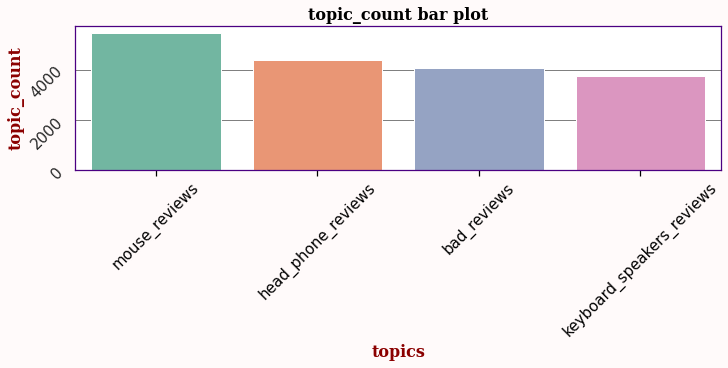

In [169]:
plotting_bar2(topics_data_count,'topics','topic_count')

### **Exporting Saved Data**

In [122]:
text_eda_data_labelled.to_csv("results/bigrams/annotated_data/raw_annotated_topics.csv",index=False)
feature_data_labelled.to_csv("results/bigrams/annotated_data/feature_engineered_annotated_topics.csv",index=False)